In [1]:
import community as cd
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
matplotlib.rcParams.update({'font.size': 18})
import numpy as np
from collections import Counter, defaultdict
from operator import itemgetter
import random
import seaborn as sns
import powerlaw
import itertools
plt.style.use('ggplot')
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

In [2]:
# Read network as directed graph from edge list
G = pd.read_csv('clean_graph.csv', delimiter=",")

# Remove two big subreddits that several different communities interact with. This makes it so that communities are more clearly defined by infomap.
G = G[G.SOURCE_SUBREDDIT != 'askreddit']
G = G[G.SOURCE_SUBREDDIT != 'iama']
G = G[G.TARGET_SUBREDDIT != 'askreddit']
G = G[G.TARGET_SUBREDDIT != 'iama']

# Separate into negative and positive
DF_POS = G[G.LINK_SENTIMENT == 1]
DF_NEG = G[G.LINK_SENTIMENT == -1]

# Load into nx
G_POS = nx.convert_matrix.from_pandas_edgelist(DF_POS, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)
G_NEG = nx.convert_matrix.from_pandas_edgelist(DF_NEG, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)

# print summary of network
print(nx.info(G_NEG))

Name: 
Type: DiGraph
Number of nodes: 4863
Number of edges: 7463
Average in degree:   1.5346
Average out degree:   1.5346


In [3]:
# Replacing strings by integers to load into igraph
nodes = set(G.SOURCE_SUBREDDIT.unique()).union(set(G.TARGET_SUBREDDIT.unique()))
nodes_dict = dict(zip(nodes, range(len(nodes))))
label_dict = dict([(value, key) for key, value in nodes_dict.items()])

DF_NEG = DF_NEG.replace(to_replace=nodes_dict)
DF_POS = DF_POS.replace(to_replace=nodes_dict)

In [4]:
# Loading into igraph
igneg = ig.Graph.TupleList(DF_NEG.itertuples(index=False), directed=True, edge_attrs="weight")
igpos = ig.Graph.TupleList(DF_POS.itertuples(index=False), directed=True, edge_attrs="weight")
# Getting the largest strongly connected component
negbc = igneg.components().giant()
posbc = igpos.components().giant()
'''
Doing infomap for community detection.
Wanted to use the fast greedy algorithm, which merges individual nodes into communities in a way that greedily maximizes the modularity score of the graph.
I thought it would be a really good idea for our realtively large network, but it has no support for directed graphs)
'''
negvertex = negbc.community_infomap(trials=20)
posvertex = posbc.community_infomap(trials=20)

In [5]:
# Plotting the biggest strongly connected components
def plotcommunity(graph, name):
    visual_style = dict()
    layout = graph.layout_fruchterman_reingold()
    visual_style["layout"] = layout
    visual_style["bbox"] = (5000, 5000)
    visual_style["margin"] = 100
    #graph.vs['label'] = label_dict[graph.vs['name']]
    #visual_style["vertex_label"] = graph.vs['label']
    visual_style["vertex_label"] = [label_dict[x] for x in graph.vs["name"]]
    out = ig.plot(graph, **visual_style)
    out.save(name + '.png')

In [10]:
posvertex5 = posbc.community_infomap(trials=5)

In [7]:
posvertex10 = posbc.community_infomap(trials=10)

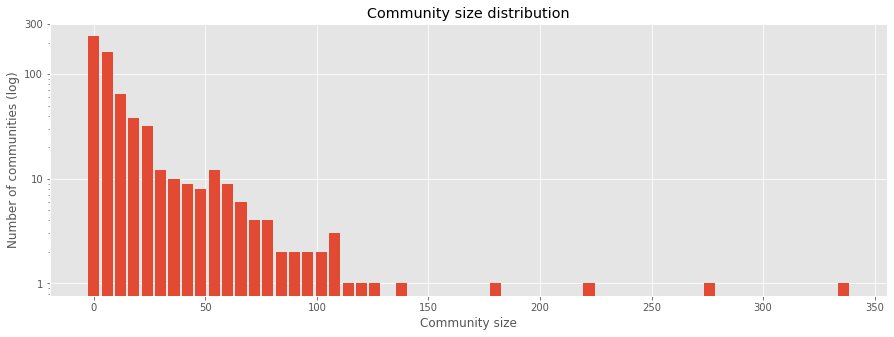

In [202]:
xs, ys = zip(*[(left, count) for left, _, count in posvertex102.size_histogram(bin_width=6).bins()])
plt.bar(xs, ys, width=5,log=1)
plt.xlabel("Community size")
plt.ylabel("Number of communities (log)")
plt.title("Community size distribution")
plt.yticks([1,10,100,300], labels=[1,10,100,300])
plt.savefig("communitySizeDistribution.png")
plt.show()


In [26]:
# Plots of biggest positive communities
ss = posvertex.sizes() 
second = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[1]))
third = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[2]))
fourth = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[3]))

plotcommunity(posvertex.giant(), "test1st")
plotcommunity(second, "test2nd")
plotcommunity(third, "test3rd")
plotcommunity(fourth, "test4th")

In [9]:
# Plots of biggest negative communities
ss = negvertex.sizes() 
second = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[1]))
third = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[2]))
fourth = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[3]))

plotcommunity(negvertex.giant(), "N1st")
plotcommunity(second, "N2nd")
plotcommunity(third, "N3rd")
plotcommunity(fourth, "N4th")